#### CNN Regression modeling used based on reference link below :
https://www.kaggle.com/gcdatkin/age-prediction-from-images-cnn-regression

In [98]:
!pip install yfinance
!pip install mplfinance
#!pip install keras-tuner

In [99]:
!pip install alpha_vantage

In [100]:
!pip install python-dotenv

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### deep_learn4.ipynb - was run for 10 year Apple prices weekly images created. 

In [102]:
import pandas as pd
path = '/content/drive/MyDrive/Data/signal10yrs.csv'
df_bonus = pd.read_csv(path)
df_bonus.head()

,Date,Signal
0,2011-07-10,0
1,2011-07-17,1
2,2011-07-24,1
3,2011-07-31,1
4,2011-08-07,0


In [103]:
import warnings
warnings.filterwarnings('ignore')

In [218]:
import numpy as np
import pandas as pd
import os
import os.path
import PIL
from PIL import Image
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import datetime
#from helper1 import add_binary_prediction

In [105]:
print(tf.__version__)

2.5.0


In [106]:
# Initial imports
from pathlib import Path

%matplotlib inline
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates
from datetime import date, timedelta
import calendar
from datetime import datetime

In [107]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [108]:
from alpha_vantage.techindicators import TechIndicators
from dotenv import load_dotenv

In [109]:
load_dotenv('/content/drive/MyDrive/Data/.env')
alpha = os.environ.get('alpha')

In [110]:
ti = TechIndicators(key=alpha, output_format='pandas')

In [111]:
data_rsi, metadata = ti.get_rsi('AAPL' )
data_macd, metadata = ti.get_macd('AAPL',)
data_sma, metadata = ti.get_sma('AAPL')
data_cci, metadata = ti.get_cci('AAPL')
data_adx, metadata = ti.get_adx('AAPL')

In [112]:
import time

In [113]:
time.sleep(60)

In [114]:
data_aroon, metadata = ti.get_aroon('AAPL')
data_vwap, metadata = ti.get_vwap('AAPL')
data_ema, metadata = ti.get_ema('AAPL')

In [115]:
data_ema.tail(10)

,EMA
date,
2021-07-26,143.1711
2021-07-27,143.4928
2021-07-28,143.6137
2021-07-29,143.7858
2021-07-30,143.9625
2021-08-02,144.0900
2021-08-03,144.3803
2021-08-04,144.6040
2021-08-05,144.8169


In [116]:
result_df = pd.concat([data_rsi, data_sma, data_macd, data_cci, data_adx, data_aroon,data_ema ], axis=1)

In [117]:
result_weekly_df = result_df.resample('W').mean()

In [118]:
result_weekly_df

,RSI,SMA,MACD_Signal,MACD_Hist,MACD,CCI,ADX,Aroon Up,Aroon Down,EMA
date,,,,,,,,,,
1999-12-05,75.835725,0.705160,NaN,NaN,NaN,215.357940,NaN,100.00,2.50,0.705840
1999-12-12,71.503280,0.751280,NaN,NaN,NaN,119.877940,NaN,94.00,6.00,0.764900
1999-12-19,56.574420,0.770740,0.04230,-0.01770,0.024600,-24.892220,NaN,70.00,10.00,0.767580
1999-12-26,57.876775,0.784850,0.03350,-0.01290,0.020600,-15.978525,NaN,47.50,18.75,0.766025
2000-01-02,55.832380,0.792280,0.02278,-0.00812,0.014700,-39.802340,40.562275,25.00,55.00,0.767460
...,...,...,...,...,...,...,...,...,...,...
2021-07-11,72.224575,133.790975,2.58485,1.04750,3.632375,169.377850,20.200900,98.75,3.75,134.992850
2021-07-18,72.152920,137.685040,3.66836,0.86680,4.535160,127.725460,25.515100,99.00,3.00,138.826060
2021-07-25,63.481740,141.264940,4.08368,-0.03224,4.051460,65.096900,27.323380,80.00,4.00,141.549860


In [119]:
ti_features_df = result_weekly_df['2011-07-10':'2021-07-04']

In [120]:
len(ti_features_df)

522

#### Dataset - directory
candlesticks_together

##### Define path for dataset

In [121]:
import pathlib
#image_dir = pathlib.Path('candlesticks10yrs/')
image_dir = pathlib.Path('/content/drive/MyDrive/Data/candlesticks10yrs/')
#data_test_dir = pathlib.Path('candlesticks_test')

### Create File DataFrame

In [122]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)

In [123]:
len(filepaths)

521

In [124]:
signal_df = pd.read_csv(path)  

In [125]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    521 non-null    object
 1   Signal  521 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.3+ KB


In [126]:
signal_df['Date']= pd.to_datetime(signal_df['Date'])

In [127]:
signal_df.set_index('Date', inplace = True)

In [128]:
signal_df.head()

,Signal
Date,
2011-07-10,0
2011-07-17,1
2011-07-24,1
2011-07-31,1
2011-08-07,0


In [129]:
signal_df.tail()

,Signal
Date,
2021-06-06,1
2021-06-13,1
2021-06-20,1
2021-06-27,1
2021-07-04,1


In [130]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2011-07-10 to 2021-07-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Signal  521 non-null    int64
dtypes: int64(1)
memory usage: 8.1 KB


In [131]:
ti_with_signal_df = pd.concat([ti_features_df,signal_df], axis=1)

In [132]:
len(ti_with_signal_df)

522

In [133]:
ti_with_signal_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 522 entries, 2011-07-10 to 2021-07-04
Freq: W-SUN
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RSI          522 non-null    float64
 1   SMA          522 non-null    float64
 2   MACD_Signal  522 non-null    float64
 3   MACD_Hist    522 non-null    float64
 4   MACD         522 non-null    float64
 5   CCI          522 non-null    float64
 6   ADX          522 non-null    float64
 7   Aroon Up     522 non-null    float64
 8   Aroon Down   522 non-null    float64
 9   EMA          522 non-null    float64
 10  Signal       521 non-null    float64
dtypes: float64(11)
memory usage: 48.9 KB


In [134]:
ti_with_signal_df.tail()

,RSI,SMA,MACD_Signal,MACD_Hist,MACD,CCI,ADX,Aroon Up,Aroon Down,EMA,Signal
2021-06-06,45.446425,125.898425,-0.941475,-0.13240,-1.073925,-77.44420,13.93430,3.75,27.5,126.205125,1.0
2021-06-13,49.458380,125.529320,-0.856960,0.21012,-0.646880,65.73302,12.64706,54.00,10.0,126.083080,1.0
2021-06-20,56.053920,126.365560,-0.243640,0.66468,0.421040,188.99882,11.53578,99.00,15.0,127.202280,1.0
2021-06-27,59.616960,127.874180,0.698520,0.76288,1.461360,138.21342,11.90108,97.00,30.0,129.146980,1.0
2021-07-04,65.002440,130.348100,1.574140,0.70096,2.275080,134.29690,14.62262,99.00,6.0,131.492000,1.0


In [135]:
len(ti_with_signal_df)

522

In [136]:
ti_features_df.tail()

,RSI,SMA,MACD_Signal,MACD_Hist,MACD,CCI,ADX,Aroon Up,Aroon Down,EMA
date,,,,,,,,,,
2021-06-06,45.446425,125.898425,-0.941475,-0.13240,-1.073925,-77.44420,13.93430,3.75,27.5,126.205125
2021-06-13,49.458380,125.529320,-0.856960,0.21012,-0.646880,65.73302,12.64706,54.00,10.0,126.083080
2021-06-20,56.053920,126.365560,-0.243640,0.66468,0.421040,188.99882,11.53578,99.00,15.0,127.202280
2021-06-27,59.616960,127.874180,0.698520,0.76288,1.461360,138.21342,11.90108,97.00,30.0,129.146980
2021-07-04,65.002440,130.348100,1.574140,0.70096,2.275080,134.29690,14.62262,99.00,6.0,131.492000


In [137]:
ind1 = ti_with_signal_df.index

In [138]:
ind1

DatetimeIndex(['2011-07-10', '2011-07-17', '2011-07-24', '2011-07-31',
               '2011-08-07', '2011-08-14', '2011-08-21', '2011-08-28',
               '2011-09-04', '2011-09-11',
               ...
               '2021-05-02', '2021-05-09', '2021-05-16', '2021-05-23',
               '2021-05-30', '2021-06-06', '2021-06-13', '2021-06-20',
               '2021-06-27', '2021-07-04'],
              dtype='datetime64[ns]', length=522, freq='W-SUN')

In [139]:
ind2 = signal_df.index

In [140]:
ind1.difference(ind2)

DatetimeIndex(['2012-11-04'], dtype='datetime64[ns]', freq=None)

In [141]:
index1 = ti_features_df.loc['2012-11-04']

In [142]:
index1

RSI             36.217800
SMA             19.391000
MACD_Signal     -0.390667
MACD_Hist       -0.119067
MACD            -0.509733
CCI           -160.524200
ADX             25.834267
Aroon Up         5.000000
Aroon Down      98.333333
EMA             19.300867
Name: 2012-11-04 00:00:00, dtype: float64

In [143]:
ti_features_df.drop(pd.to_datetime('2012-11-04'), inplace=True)

In [144]:
len(ti_features_df)

521

In [145]:
ti_with_signal_df.drop(pd.to_datetime('2012-11-04'), inplace=True)

In [146]:
len(ti_with_signal_df)

521

In [147]:
signal_df['2012-10-04':'2012-12-04']

,Signal
Date,
2012-10-07,0
2012-10-14,1
2012-10-21,1
2012-10-28,0
2012-11-11,0
2012-11-18,1
2012-11-25,1
2012-12-02,1


In [148]:
X = ti_features_df

In [149]:
y = signal_df

In [150]:
X.shape

(521, 10)

In [151]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [152]:
X_train.shape

(364, 10)

In [153]:
y_train.shape

(364, 1)

In [154]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [155]:
X_train.shape

(364, 10)

In [156]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.56743903]
  [0.        ]
  [0.35043784]
  [0.64106509]
  [0.38210284]
  [0.89247981]
  [0.15233012]
  [1.        ]
  [0.425     ]
  [0.        ]]

 [[0.56392938]
  [0.0015179 ]
  [0.36136495]
  [0.6366245 ]
  [0.39094148]
  [0.70726486]
  [0.16883808]
  [0.97      ]
  [0.2       ]
  [0.00176026]]

 [[0.75691481]
  [0.00450297]
  [0.37296224]
  [0.64306172]
  [0.40404546]
  [0.79132392]
  [0.24910907]
  [0.97      ]
  [0.02      ]
  [0.00462854]]

 [[0.75392791]
  [0.00845509]
  [0.38703614]
  [0.6393194 ]
  [0.41609413]
  [0.70493243]
  [0.37726799]
  [0.94      ]
  [0.01      ]
  [0.00837506]]

 [[0.56547643]
  [0.01134283]
  [0.39067594]
  [0.60694238]
  [0.40873429]
  [0.54047909]
  [0.38724038]
  [0.7       ]
  [0.05      ]
  [0.01029418]]] 

X_test sample values:
[[[0.38018078]
  [0.28014502]
  [0.35368525]
  [0.58244822]
  [0.36561825]
  [0.39283353]
  [0.12878965]
  [0.075     ]
  [0.675     ]
  [0.27941271]]

 [[0.47939888]
  [0.27870286]
  [0.355470

In [157]:
X_train.shape

(364, 10, 1)

In [158]:
# # Split the dataset into training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [159]:
# # Create the StandardScaler instances
# scaler = StandardScaler()

In [160]:
# # Scale the training and testing input features using StandardScaler
# X_scaler = StandardScaler()
# X_scaler.fit(X_train)

# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

### Build a Deep Neural Network

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout

In [163]:
X_train.shape

(364, 10, 1)

In [197]:
# Define the LSTM RNN model.
model_lstm = Sequential()

In [190]:
model_lstm.summary()

ValueError: ignored

In [198]:


number_units = 96
dropout_fraction = 0.2

# Layer 1
model_lstm.add(LSTM(
    units=number_units,
#    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
#    input_dim=X_train.shape[1]
    )
model_lstm.add(Dropout(dropout_fraction))
# # Layer 2
#model_lstm.add(LSTM(units=number_units, return_sequences=True))
#model_lstm.add(Dropout(dropout_fraction))
# # Layer 3
# model_lstm.add(LSTM(units=number_units))
# model_lstm.add(Dropout(dropout_fraction))
# Output layer
model_lstm.add(Dense(1))

In [200]:
# Compile the model
model_lstm.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])

In [201]:
# Summarize the model
model_lstm.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 96)                37632     
_________________________________________________________________
dropout_11 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 37,729
Trainable params: 37,729
Non-trainable params: 0
_________________________________________________________________


In [202]:
# Train the model
model_lstm.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
364/364 [==============================] - 8s 3ms/step - loss: 0.2575 - accuracy: 0.5440
Epoch 2/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2468 - accuracy: 0.5632
Epoch 3/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2432 - accuracy: 0.5824
Epoch 4/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2448 - accuracy: 0.5440
Epoch 5/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2452 - accuracy: 0.5604
Epoch 6/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2428 - accuracy: 0.5632
Epoch 7/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2440 - accuracy: 0.5687
Epoch 8/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2442 - accuracy: 0.5495
Epoch 9/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2486 - accuracy: 0.5357
Epoch 10/10
364/364 [==============================] - 1s 3ms/step - loss: 0.2418 - accuracy: 0.5852

In [204]:
# Evaluate the model
model_lstm.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.2519 - accuracy: 0.4522


[0.25187981128692627, 0.4522292912006378]

In [206]:
# Make some predictions
predicted = model_lstm.predict(X_test)

In [207]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [213]:
filepaths[0]

'/content/drive/MyDrive/Data/candlesticks10yrs/2011-07-10.png'

In [215]:
dtstr = os.path.split(filepaths[0])[1].split(".")[0]

In [216]:
dtstr

'2011-07-10'

In [219]:
datetime.datetime.strptime(dtstr, '%Y-%m-%d').date()

datetime.date(2011, 7, 10)

In [220]:
date_list = []
for i in filepaths:
    #print(i)
    dtstr = os.path.split(i)[1].split(".")[0]
    #print(dtstr)
    #print(datetime.datetime.strptime(dtstr, '%Y-%m-%d').date())
    date_list.append(datetime.datetime.strptime(dtstr, '%Y-%m-%d').date())
    

In [221]:
#date_list

In [222]:
images_df = pd.DataFrame()
images_df['Date'] = date_list 
images_df['Filepath'] =  filepaths

In [223]:
images_df['Date']= pd.to_datetime(images_df['Date'])

In [224]:
images_df.head()

,Date,Filepath
0,2011-07-10,/content/drive/MyDrive/Data/candlesticks10yrs/...
1,2011-07-17,/content/drive/MyDrive/Data/candlesticks10yrs/...
2,2011-08-07,/content/drive/MyDrive/Data/candlesticks10yrs/...
3,2011-08-14,/content/drive/MyDrive/Data/candlesticks10yrs/...
4,2011-07-31,/content/drive/MyDrive/Data/candlesticks10yrs/...


In [225]:
images_df.set_index('Date', inplace=True)

In [226]:
images_df.head()

,Filepath
Date,
2011-07-10,/content/drive/MyDrive/Data/candlesticks10yrs/...
2011-07-17,/content/drive/MyDrive/Data/candlesticks10yrs/...
2011-08-07,/content/drive/MyDrive/Data/candlesticks10yrs/...
2011-08-14,/content/drive/MyDrive/Data/candlesticks10yrs/...
2011-07-31,/content/drive/MyDrive/Data/candlesticks10yrs/...


In [227]:
images_df.index

DatetimeIndex(['2011-07-10', '2011-07-17', '2011-08-07', '2011-08-14',
               '2011-07-31', '2011-07-24', '2011-08-21', '2011-09-25',
               '2011-08-28', '2011-09-18',
               ...
               '2021-05-02', '2021-05-09', '2021-05-16', '2021-05-23',
               '2021-05-30', '2021-06-06', '2021-06-13', '2021-06-20',
               '2021-06-27', '2021-07-04'],
              dtype='datetime64[ns]', name='Date', length=521, freq=None)

In [228]:
images = pd.concat([images_df,signal_df], join='inner', axis=1)

In [229]:
images.head(10)

,Filepath,Signal
Date,,
2011-07-10,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
2011-07-17,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
2011-08-07,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
2011-08-14,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
2011-07-31,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
2011-07-24,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
2011-08-21,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
2011-09-25,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
2011-08-28,/content/drive/MyDrive/Data/candlesticks10yrs/...,1


In [230]:
# Let's only use 40 images to speed up training time
image_df = images.sample(421, random_state=1).reset_index(drop=True)
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [231]:
train_df.head()

,Filepath,Signal
385,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
186,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
27,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
89,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
327,/content/drive/MyDrive/Data/candlesticks10yrs/...,1


In [232]:
test_df.head()

,Filepath,Signal
378,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
165,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
17,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
179,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
4,/content/drive/MyDrive/Data/candlesticks10yrs/...,0


### Loading Images

In [233]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [234]:
train_df

,Filepath,Signal
385,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
186,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
27,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
89,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
327,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
...,...,...
255,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
72,/content/drive/MyDrive/Data/candlesticks10yrs/...,0
396,/content/drive/MyDrive/Data/candlesticks10yrs/...,1
235,/content/drive/MyDrive/Data/candlesticks10yrs/...,0


In [235]:
train_df['Signal'].value_counts()

1    173
0    121
Name: Signal, dtype: int64

In [236]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Signal',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    #batch_size=32,
    batch_size=1,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Signal',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    #batch_size=32,
    batch_size=1,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Signal',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    #batch_size=32,
    batch_size=1,
    shuffle=False
)

Found 236 validated image filenames.
Found 58 validated image filenames.
Found 127 validated image filenames.


### Training

In [237]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
print('after 1st conv2d - ',x)
x = tf.keras.layers.MaxPool2D()(x)
print('after 1st maxpool2d - ',x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
print('after 2nd conv2d - ',x)
x = tf.keras.layers.MaxPool2D()(x)
print('after 2nd maxpool2d - ',x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print('after 1st GlobalAvgPooling2D - ',x)
features_x = x
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

after 1st conv2d -  KerasTensor(type_spec=TensorSpec(shape=(None, 118, 118, 16), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
after 1st maxpool2d -  KerasTensor(type_spec=TensorSpec(shape=(None, 59, 59, 16), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
after 2nd conv2d -  KerasTensor(type_spec=TensorSpec(shape=(None, 57, 57, 32), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
after 2nd maxpool2d -  KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 32), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
after 1st GlobalAvgPooling2D -  KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")
Epoch 1/100
236/236 [=============================

In [238]:
print(features_x)

KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")


### Results

In [239]:
predicted_signals = np.squeeze(model.predict(test_images))
true_signals = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
# print(type(rmse))
# print(len(rmse))
# print(rmse)
print("     Test RMSE1: {:.5f}".format(rmse[0]))
print("     Test RMSE2: {:.5f}".format(rmse[1]))
r2 = r2_score(true_signals, predicted_signals)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE1: 0.82271
     Test RMSE2: 0.76847
Test R^2 Score: -0.00039


In [240]:
null_rmse = np.sqrt(np.sum((true_signals - np.mean(true_signals))**2) / len(true_signals))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 0.49173


## We can see that our model is not even better than the null/baseline model (predict mean every time)!

In [241]:
true_signals.shape

(127,)

In [242]:
true_signals

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])

In [243]:
predicted_signals.shape

(127,)

In [244]:
predicted_signals

array([0.59257776, 0.5880886 , 0.5781454 , 0.59530044, 0.5903045 ,
       0.58723485, 0.6032256 , 0.5980263 , 0.57067835, 0.58420974,
       0.58602726, 0.59920317, 0.5929779 , 0.58532256, 0.5991434 ,
       0.5925732 , 0.58386165, 0.60238826, 0.5934175 , 0.6021685 ,
       0.5957802 , 0.5935979 , 0.5806315 , 0.58612776, 0.5834356 ,
       0.6081821 , 0.58998984, 0.6150934 , 0.58749354, 0.58847237,
       0.58739597, 0.5759331 , 0.590769  , 0.58588743, 0.5855296 ,
       0.57744724, 0.5899251 , 0.5794255 , 0.5838848 , 0.5915378 ,
       0.57956046, 0.60049367, 0.589092  , 0.5898732 , 0.5912765 ,
       0.5941533 , 0.5916493 , 0.58862376, 0.59517795, 0.58100635,
       0.5899113 , 0.60289025, 0.58995485, 0.5753587 , 0.6102633 ,
       0.59010935, 0.58688605, 0.5803439 , 0.61050844, 0.585832  ,
       0.59293944, 0.590951  , 0.5980275 , 0.5916662 , 0.582231  ,
       0.60132176, 0.58853096, 0.5944467 , 0.5891288 , 0.5875773 ,
       0.5847944 , 0.6004152 , 0.59738714, 0.58509946, 0.58518

In [245]:
len(true_signals)

127

In [246]:
len(predicted_signals)

127

In [247]:
final_predictions_df = pd.DataFrame()
final_predictions_df['Actual'] = true_signals
final_predictions_df['Predicted'] =  predicted_signals

In [248]:
final_predictions_df

,Actual,Predicted
0,1,0.592578
1,1,0.588089
2,1,0.578145
3,1,0.595300
4,0,0.590304
...,...,...
122,1,0.589152
123,1,0.591555
124,0,0.586227
125,1,0.584095


In [249]:
def add_binary_prediction(df1):
    binary_signal = []
    for index, row in df1.iterrows():
    #print(row[1])
        if row[1] > 0.5:
            binary_signal.append('1')
        else:
            binary_signal.append('0')
    df1['binary_prediction'] = binary_signal
    return df1

In [250]:
final_predictions_df = add_binary_prediction(final_predictions_df)

In [251]:
final_predictions_df

,Actual,Predicted,binary_prediction
0,1,0.592578,1
1,1,0.588089,1
2,1,0.578145,1
3,1,0.595300,1
4,0,0.590304,1
...,...,...,...
122,1,0.589152,1
123,1,0.591555,1
124,0,0.586227,1
125,1,0.584095,1


In [252]:
binary_signal = []
for index, row in final_predictions_df.iterrows():
    #print(row[1])
    if row[1] > 0.5:
        binary_signal.append(1)
    else:
        binary_signal.append(0)

In [253]:
final_predictions_df['binary_prediction'] = binary_signal

In [254]:
final_predictions_df.head()

,Actual,Predicted,binary_prediction
0,1,0.592578,1
1,1,0.588089,1
2,1,0.578145,1
3,1,0.595300,1
4,0,0.590304,1


In [255]:
final_predictions_df['Actual'].value_counts()

1    75
0    52
Name: Actual, dtype: int64

In [256]:
final_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Actual             127 non-null    int64  
 1   Predicted          127 non-null    float32
 2   binary_prediction  127 non-null    int64  
dtypes: float32(1), int64(2)
memory usage: 2.6 KB


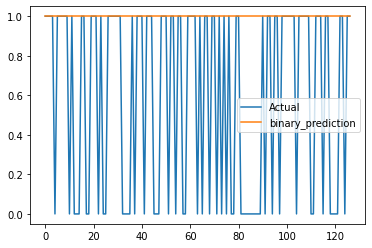

In [257]:
final_predictions_binary_df = final_predictions_df.drop(columns=['Predicted'])
final_predictions_binary_df.plot()

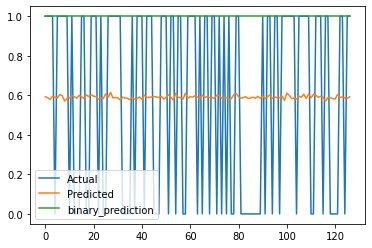

In [258]:
final_predictions_df.plot()

In [260]:
#train_index = X_train

In [261]:
merged = Concatenate()([model_lstm.output,model.output])
z = Dense(128, activation="relu")(merged)
z = Dropout(0.25)(z)
z = Dense(1024, activation="relu")(z)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[model_lstm.input, model.input], outputs=z)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


#model.fit([x_train[train_index][:,:66], x_train[train_index][:,66:132], y_train[train_index], batch_size=100, epochs=100, verbose=2)


NameError: ignored